In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
tf.keras.utils.set_random_seed(4)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
print("Device:", tpu.master())

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.54.53.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.54.53.138:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Device: grpc://10.54.53.138:8470


In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [4]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#getting dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [6]:
#checking train and test size
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


##EDA

In [7]:
#Look at labels for training set- they are numeric
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]



In [8]:
# function to help plot some of the pictures from the dataset
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [9]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [10]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

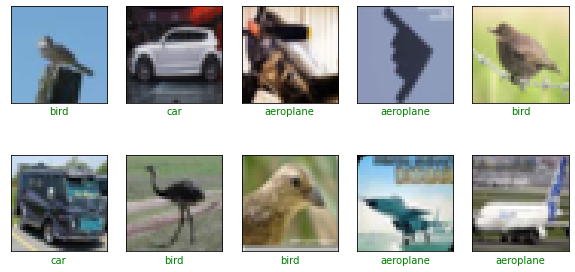

In [11]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

# Data Preprocessing

In [12]:
#use train_test_split to create validation set.
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=10
                                                                              ,shuffle=True)

In [13]:
#looking at train, validation and test set shapes
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [14]:
#scaling the train, validation and test sets by 255. Equivelant to min_max scaling

x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# Helpful Model Fitting and Results Functions

In [15]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [16]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer='adam',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=512,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=2),
          
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') 
                                                                        
  

    return history, model

In [17]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [18]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [19]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [20]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                     #index = [0,1,2,3,4,5,6,7,8,9], 
                     #columns = [0,1,2,3,4,5,6,7,8,9]
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# Experiment 5a_1 - ANN with 2 Dense Hidden Layer and Dropout

In [21]:
#Experiment 5a_1 model
def create_model_exp_5a_1():
    model = Sequential()
    model.add(Flatten(input_shape=(32,32,3)))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.30))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.30))
    model.add(Dense(10, activation = "softmax"))
    return model


In [22]:
#TPU Strategy
strategy_exp_5a_1  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [23]:
#assigning model to TPU strategy
with strategy_exp_5a_1.scope():
    model_exp_5a_1 = create_model_exp_5a_1()

model_exp_5a_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 411,146
Trainable params: 411,146
Non-trai

In [24]:
# Compile and train
epochs=100
patience=3
model_number="5a_1"
history_exp_5a_1, model_exp_5a_1 = compile_train_model(model_exp_5a_1,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 4/88 [>.............................] - ETA: 1s - loss: 2.5622 - accuracy: 0.1123  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0013s vs `on_train_batch_end` time: 0.1917s). Check your callbacks.


88/88 [==============================] - 8s 57ms/step - loss: 2.1563 - accuracy: 0.1905 - val_loss: 1.9787 - val_accuracy: 0.2998
Epoch 2/100
88/88 [==============================] - 2s 22ms/step - loss: 2.0001 - accuracy: 0.2648 - val_loss: 1.9110 - val_accuracy: 0.3254
Epoch 3/100
88/88 [==============================] - 2s 22ms/step - loss: 1.9396 - accuracy: 0.2939 - val_loss: 1.8484 - val_accuracy: 0.3432
Epoch 4/100
88/88 [==============================] - 2s 22ms/step - loss: 1.9099 - accuracy: 0.3000 - val_loss: 1.8337 - val_accuracy: 0.3602
Epoch 5/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8816 - accuracy: 0.3105 - val_loss: 1.7850 - val_accuracy: 0.3678
Epoch 6/100
88/88 [==============================] - 2s 22ms/step - loss: 1.8679 - accuracy: 0.3168 - val_loss: 1.7782 - val_accuracy: 0.3704
Epoch 7/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8496 - accuracy: 0.3254 - val_loss: 1.7775 - val_accuracy: 0.3684
Epoch 8/100
88/88 

In [25]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_5a_1, model_number, epochs, patience=patience)

Model Experiment 5a_1  Training Loss:  1.7788
Model Experiment 5a_1  Training Accuracy:  0.3525
Model Experiment 5a_1  Validation Loss:  1.7291
Model Experiment 5a_1  Validation Accuracy: 0.3988


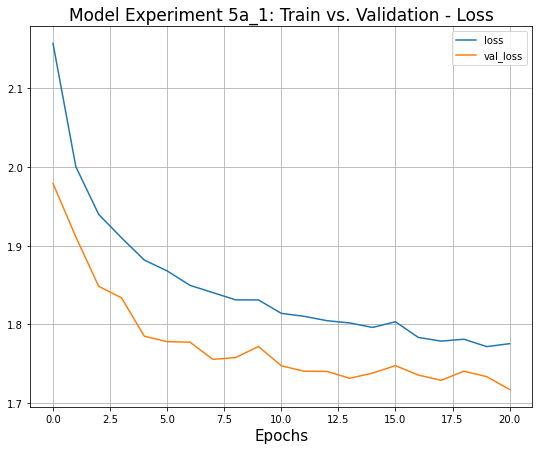

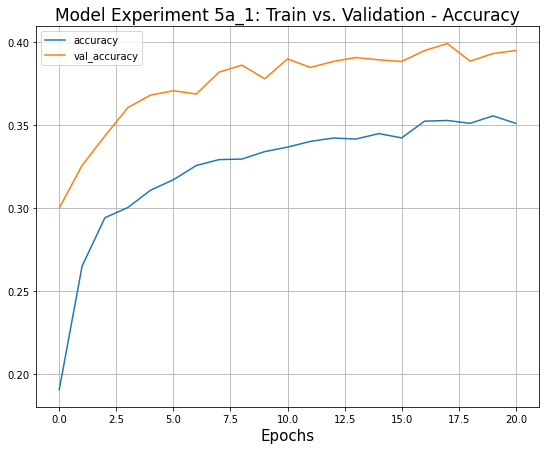

In [26]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_5a_1, model_number)

In [27]:
#creating  classification report

#getting predictions

model_exp_5a_1_predictions=model_exp_5a_1.predict(x_test_norm).argmax(axis=1)
print_validation_report(test_labels, model_exp_5a_1_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.47      0.47      1000
           1       0.59      0.44      0.50      1000
           2       0.24      0.17      0.20      1000
           3       0.29      0.16      0.21      1000
           4       0.32      0.34      0.33      1000
           5       0.40      0.30      0.34      1000
           6       0.35      0.63      0.45      1000
           7       0.47      0.45      0.46      1000
           8       0.50      0.46      0.48      1000
           9       0.40      0.62      0.49      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.39     10000
weighted avg       0.40      0.40      0.39     10000

Accuracy Score: 0.4039
Root Mean Square Error: 3.401646660075088


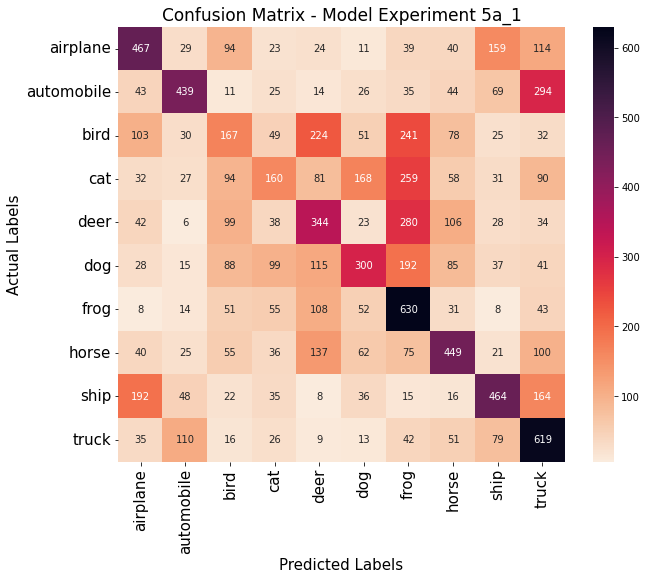

In [28]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_5a_1, x_test_norm, y_test, model_number)

# Experiment 5a_2 - ANN with 3 Dense Hidden Layer with Dropout

In [41]:
#Experiment 5a_2 model
def create_model_exp_5a_2():
    model = Sequential() 
    model.add(Flatten(input_shape=(32,32,3)))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.30))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.30))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.30))
    model.add(Dense(10, activation = "softmax"))
    return model



In [42]:
#TPU Strategy
strategy_exp_5a_2  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [43]:
#assigning model to tpu strategy
with strategy_exp_5a_2.scope():
    model_exp_5a_2 = create_model_exp_5a_2()

model_exp_5a_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               393344    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)              

In [44]:
# Compile and train
epochs=100
patience=3
model_number="5a_2"
history_exp_5a_2, model_exp_5a_2 = compile_train_model(model_exp_5a_2,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 5/88 [>.............................] - ETA: 1s - loss: 2.4012 - accuracy: 0.1098  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.1979s). Check your callbacks.


88/88 [==============================] - 8s 56ms/step - loss: 2.1372 - accuracy: 0.1914 - val_loss: 1.9511 - val_accuracy: 0.2986
Epoch 2/100
88/88 [==============================] - 2s 23ms/step - loss: 1.9707 - accuracy: 0.2686 - val_loss: 1.8654 - val_accuracy: 0.3334
Epoch 3/100
88/88 [==============================] - 2s 22ms/step - loss: 1.9179 - accuracy: 0.2927 - val_loss: 1.8165 - val_accuracy: 0.3418
Epoch 4/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8901 - accuracy: 0.3054 - val_loss: 1.7898 - val_accuracy: 0.3696
Epoch 5/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8661 - accuracy: 0.3162 - val_loss: 1.8142 - val_accuracy: 0.3542
Epoch 6/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8581 - accuracy: 0.3175 - val_loss: 1.7414 - val_accuracy: 0.3806
Epoch 7/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8354 - accuracy: 0.3279 - val_loss: 1.7715 - val_accuracy: 0.3808
Epoch 8/100
88/88 

In [45]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_5a_2, model_number, epochs, patience=patience)

Model Experiment 5a_2  Training Loss:  1.8219
Model Experiment 5a_2  Training Accuracy:  0.333
Model Experiment 5a_2  Validation Loss:  1.7588
Model Experiment 5a_2  Validation Accuracy: 0.3868


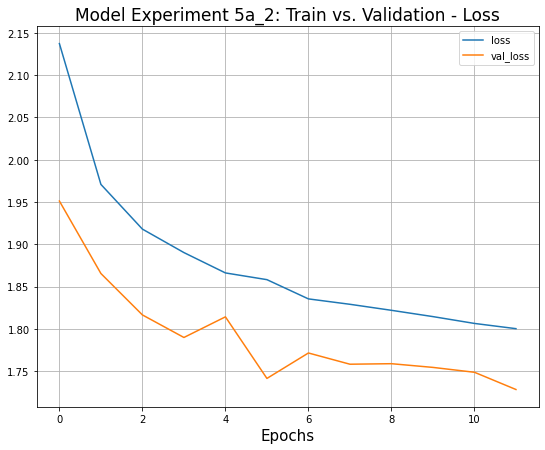

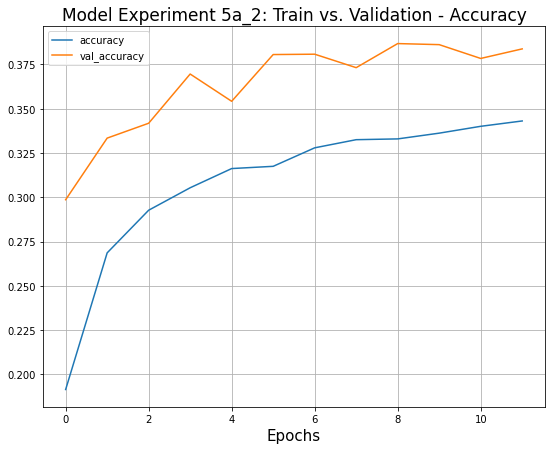

In [46]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_5a_2, model_number)

In [47]:
#creating  classification report

#getting predictions

model_exp_5a_2_predictions=model_exp_5a_2.predict(x_test_norm).argmax(axis=1)
print_validation_report(test_labels, model_exp_5a_2_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.43      0.49      0.46      1000
           1       0.38      0.60      0.47      1000
           2       0.27      0.16      0.20      1000
           3       0.29      0.18      0.22      1000
           4       0.31      0.41      0.35      1000
           5       0.49      0.18      0.26      1000
           6       0.34      0.61      0.44      1000
           7       0.43      0.43      0.43      1000
           8       0.51      0.35      0.41      1000
           9       0.45      0.44      0.45      1000

    accuracy                           0.38     10000
   macro avg       0.39      0.38      0.37     10000
weighted avg       0.39      0.38      0.37     10000

Accuracy Score: 0.3836
Root Mean Square Error: 3.457325555975312


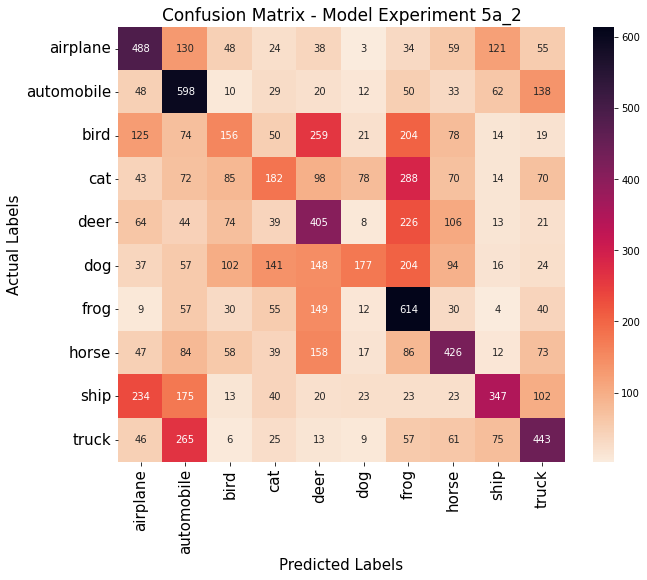

In [48]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_5a_2, x_test_norm, y_test, model_number)

# Experiment 5a_3 - CNN with 2 sets of Conv2D/MaxPool2D layers and 1 Dense Layer. Includes Dropout and Batch Normalization

In [49]:
#Experiment 5a_3 model
def create_model_exp_5a_3():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(5,5), activation="relu", padding="same", input_shape=[32,32,3]))
    model.add(MaxPool2D(2, strides=1))
    model.add(Dropout(0.30))
    model.add(Conv2D(256, kernel_size=(3,3), activation="relu", padding="same"))
    model.add(MaxPool2D(2, strides=1))
    model.add(Dropout(0.30))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.30))
    model.add(Dense(10, activation = "softmax"))
    return model



In [50]:
#TPU Strategy
strategy_exp_5a_3  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [51]:
#assigning model to tpu strategy
with strategy_exp_5a_3.scope():
    model_exp_5a_3 = create_model_exp_5a_3()

model_exp_5a_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       9728      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 31, 31, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 256)      

In [52]:
# Compile and train
epochs=100
patience=3
model_number="5a_3"
history_exp_5a_3, model_exp_5a_3 = compile_train_model(model_exp_5a_3,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 6/88 [=>............................] - ETA: 4s - loss: 2.6406 - accuracy: 0.2155WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.8735s). Check your callbacks.


88/88 [==============================] - 24s 195ms/step - loss: 1.6033 - accuracy: 0.4429 - val_loss: 1.3248 - val_accuracy: 0.5314
Epoch 2/100
88/88 [==============================] - 6s 67ms/step - loss: 1.1519 - accuracy: 0.5950 - val_loss: 1.4325 - val_accuracy: 0.4934
Epoch 3/100
88/88 [==============================] - 6s 67ms/step - loss: 0.9803 - accuracy: 0.6579 - val_loss: 1.6737 - val_accuracy: 0.4392
Epoch 4/100
88/88 [==============================] - 7s 76ms/step - loss: 0.8653 - accuracy: 0.6978 - val_loss: 1.0818 - val_accuracy: 0.6368
Epoch 5/100
88/88 [==============================] - 6s 67ms/step - loss: 0.7847 - accuracy: 0.7264 - val_loss: 1.3619 - val_accuracy: 0.5530
Epoch 6/100
88/88 [==============================] - 7s 75ms/step - loss: 0.7130 - accuracy: 0.7507 - val_loss: 0.8826 - val_accuracy: 0.6994
Epoch 7/100
88/88 [==============================] - 7s 76ms/step - loss: 0.6226 - accuracy: 0.7819 - val_loss: 0.8675 - val_accuracy: 0.7038
Epoch 8/100
88/8

In [53]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_5a_3, model_number, epochs, patience=patience)

Model Experiment 5a_3  Training Loss:  0.6226
Model Experiment 5a_3  Training Accuracy:  0.7819
Model Experiment 5a_3  Validation Loss:  0.8675
Model Experiment 5a_3  Validation Accuracy: 0.7038


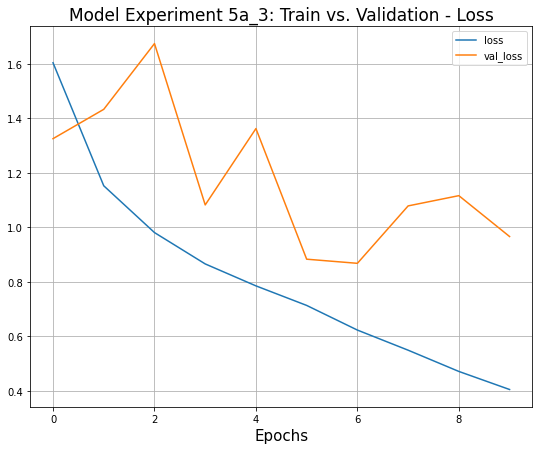

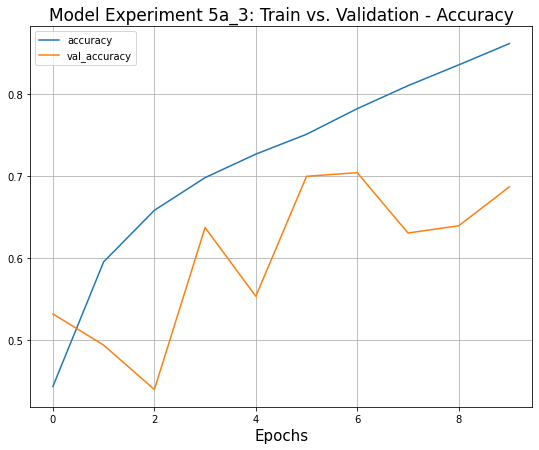

In [54]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_5a_3, model_number)

In [55]:
#creating  classification report

#getting predictions

model_exp_5a_3_predictions=model_exp_5a_3.predict(x_test_norm).argmax(axis=1)
print_validation_report(test_labels, model_exp_5a_3_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.64      0.72      1000
           1       0.81      0.84      0.83      1000
           2       0.55      0.62      0.58      1000
           3       0.53      0.55      0.54      1000
           4       0.60      0.69      0.64      1000
           5       0.67      0.61      0.64      1000
           6       0.68      0.85      0.75      1000
           7       0.80      0.73      0.77      1000
           8       0.88      0.76      0.81      1000
           9       0.84      0.77      0.81      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

Accuracy Score: 0.7069
Root Mean Square Error: 2.1431985442324284


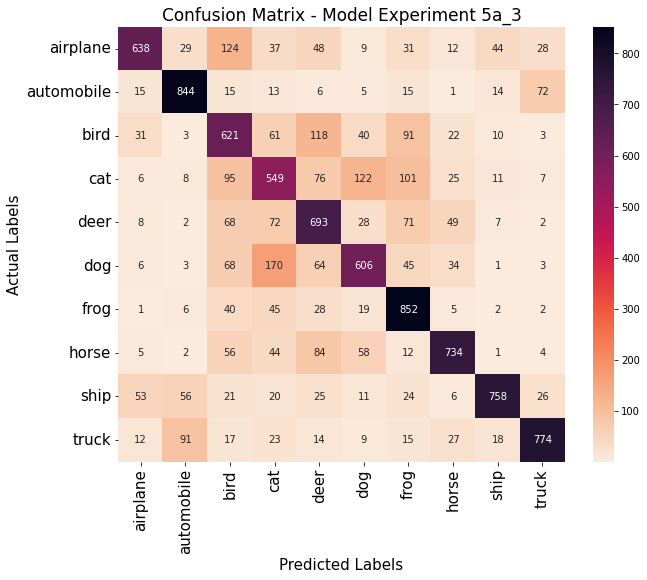

In [56]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_5a_3, x_test_norm, y_test, model_number)

# Experiment 5a_4 - CNN with 3 sets of Conv2D/MaxPool2D layers and 1 Dense Layer. Includes Dropout and Batch Normalization

In [57]:
#Experiment 5a_4 model
def create_model_exp_5a_4():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(5,5), activation="relu", padding="same", input_shape=[32,32,3]))
    model.add(MaxPool2D(2, strides=1))
    model.add(Dropout(0.30))
    model.add(Conv2D(256, kernel_size=(3,3), activation="relu", padding="same"))
    model.add(MaxPool2D(2, strides=1))
    model.add(Dropout(0.30))
    model.add(Conv2D(512, kernel_size=(3,3), activation="relu", padding="same"))
    model.add(MaxPool2D(2, strides=1))
    model.add(Dropout(0.30))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.30))
    model.add(Dense(10, activation = "softmax"))
    return model



In [58]:
strategy_exp_5a_4  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [59]:
with strategy_exp_5a_4.scope():
    model_exp_5a_4 = create_model_exp_5a_4()

model_exp_5a_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       9728      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 31, 31, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 30, 30, 256)      

In [60]:
# Compile and train
epochs=100
patience=3
model_number="5a_4"
history_exp_5a_4, model_exp_5a_4 = compile_train_model(model_exp_5a_4,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 6/88 [=>............................] - ETA: 9s - loss: 2.7655 - accuracy: 0.1969WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 1.4876s). Check your callbacks.


88/88 [==============================] - 42s 354ms/step - loss: 1.7562 - accuracy: 0.3874 - val_loss: 1.5747 - val_accuracy: 0.4704
Epoch 2/100
88/88 [==============================] - 11s 121ms/step - loss: 1.2764 - accuracy: 0.5466 - val_loss: 1.7744 - val_accuracy: 0.3444
Epoch 3/100
88/88 [==============================] - 12s 138ms/step - loss: 1.0568 - accuracy: 0.6280 - val_loss: 1.4977 - val_accuracy: 0.4964
Epoch 4/100
88/88 [==============================] - 12s 137ms/step - loss: 0.9285 - accuracy: 0.6744 - val_loss: 1.1774 - val_accuracy: 0.5944
Epoch 5/100
88/88 [==============================] - 12s 137ms/step - loss: 0.8269 - accuracy: 0.7091 - val_loss: 1.0664 - val_accuracy: 0.6246
Epoch 6/100
88/88 [==============================] - 11s 123ms/step - loss: 0.7528 - accuracy: 0.7363 - val_loss: 1.2164 - val_accuracy: 0.5952
Epoch 7/100
88/88 [==============================] - 12s 138ms/step - loss: 0.6626 - accuracy: 0.7698 - val_loss: 1.0377 - val_accuracy: 0.6428
Epoc

In [61]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_5a_4, model_number, epochs, patience=patience)

Model Experiment 5a_4  Training Loss:  0.4284
Model Experiment 5a_4  Training Accuracy:  0.8515
Model Experiment 5a_4  Validation Loss:  0.7539
Model Experiment 5a_4  Validation Accuracy: 0.754


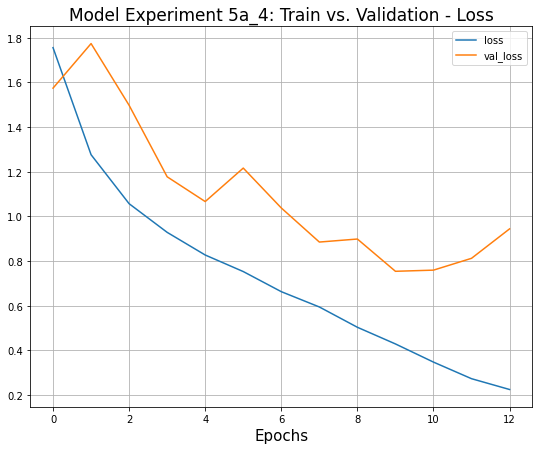

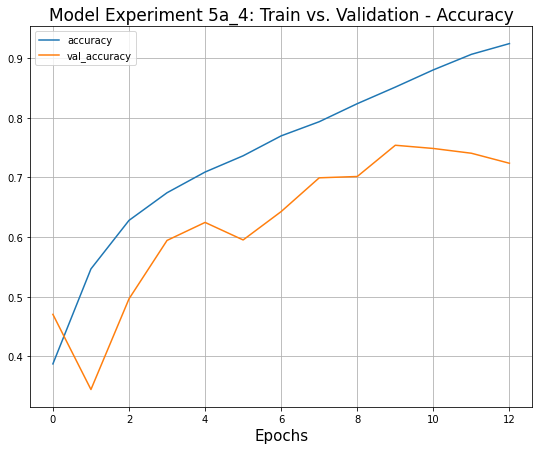

In [62]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_5a_4, model_number)

In [63]:
#creating  classification report

#getting predictions

model_exp_5a_4_predictions=model_exp_5a_4.predict(x_test_norm).argmax(axis=1)
print_validation_report(test_labels, model_exp_5a_4_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1000
           1       0.85      0.89      0.87      1000
           2       0.71      0.58      0.64      1000
           3       0.64      0.56      0.59      1000
           4       0.61      0.80      0.69      1000
           5       0.75      0.59      0.66      1000
           6       0.76      0.85      0.80      1000
           7       0.79      0.81      0.80      1000
           8       0.82      0.88      0.85      1000
           9       0.82      0.84      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.75     10000
weighted avg       0.76      0.76      0.75     10000

Accuracy Score: 0.7551
Root Mean Square Error: 2.0390929355966096


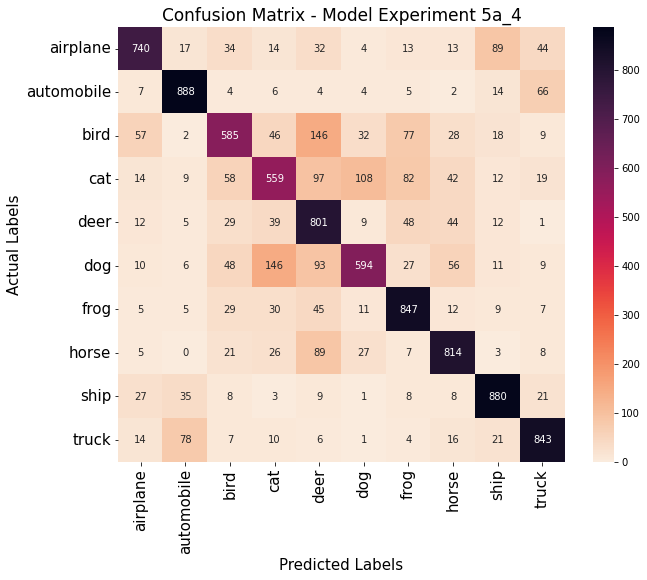

In [64]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_5a_4, x_test_norm, y_test, model_number)